# Data Collection

Tutorial for data gathering https://github.com/Shirleyiscool/Scraping-Sephora

In [2]:
import pandas as pd
import pickle
import json
import re
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from tqdm import tqdm
import time
import os

pd.options.display.max_rows = 999

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive'
}

# Step 1: Extract the Product List from the URL

This step involves using a browser to extract all lipstick product information 
from Sephora's lipstick catalog page. The raw JSON data will be accessed and 
merged for further analysis.

Steps:
1. Open Google Chrome and navigate to the Sephora lipstick catalog page: 
   https://www.sephora.com/shop/lips-makeup.
2. Right-click anywhere on the page and select "Inspect" to open the Developer Tools.
3. In the Developer Tools, follow these steps:
   a. Navigate to the "Network" tab.
   b. Filter for "Fetch/XHR" requests.
   c. Look for the request named `browseSearchProduct`.
   d. Click on the request, and then navigate to the "Response" tab to view the raw JSON data.
4. Copy the JSON data for analysis and save it for processing in this notebook.

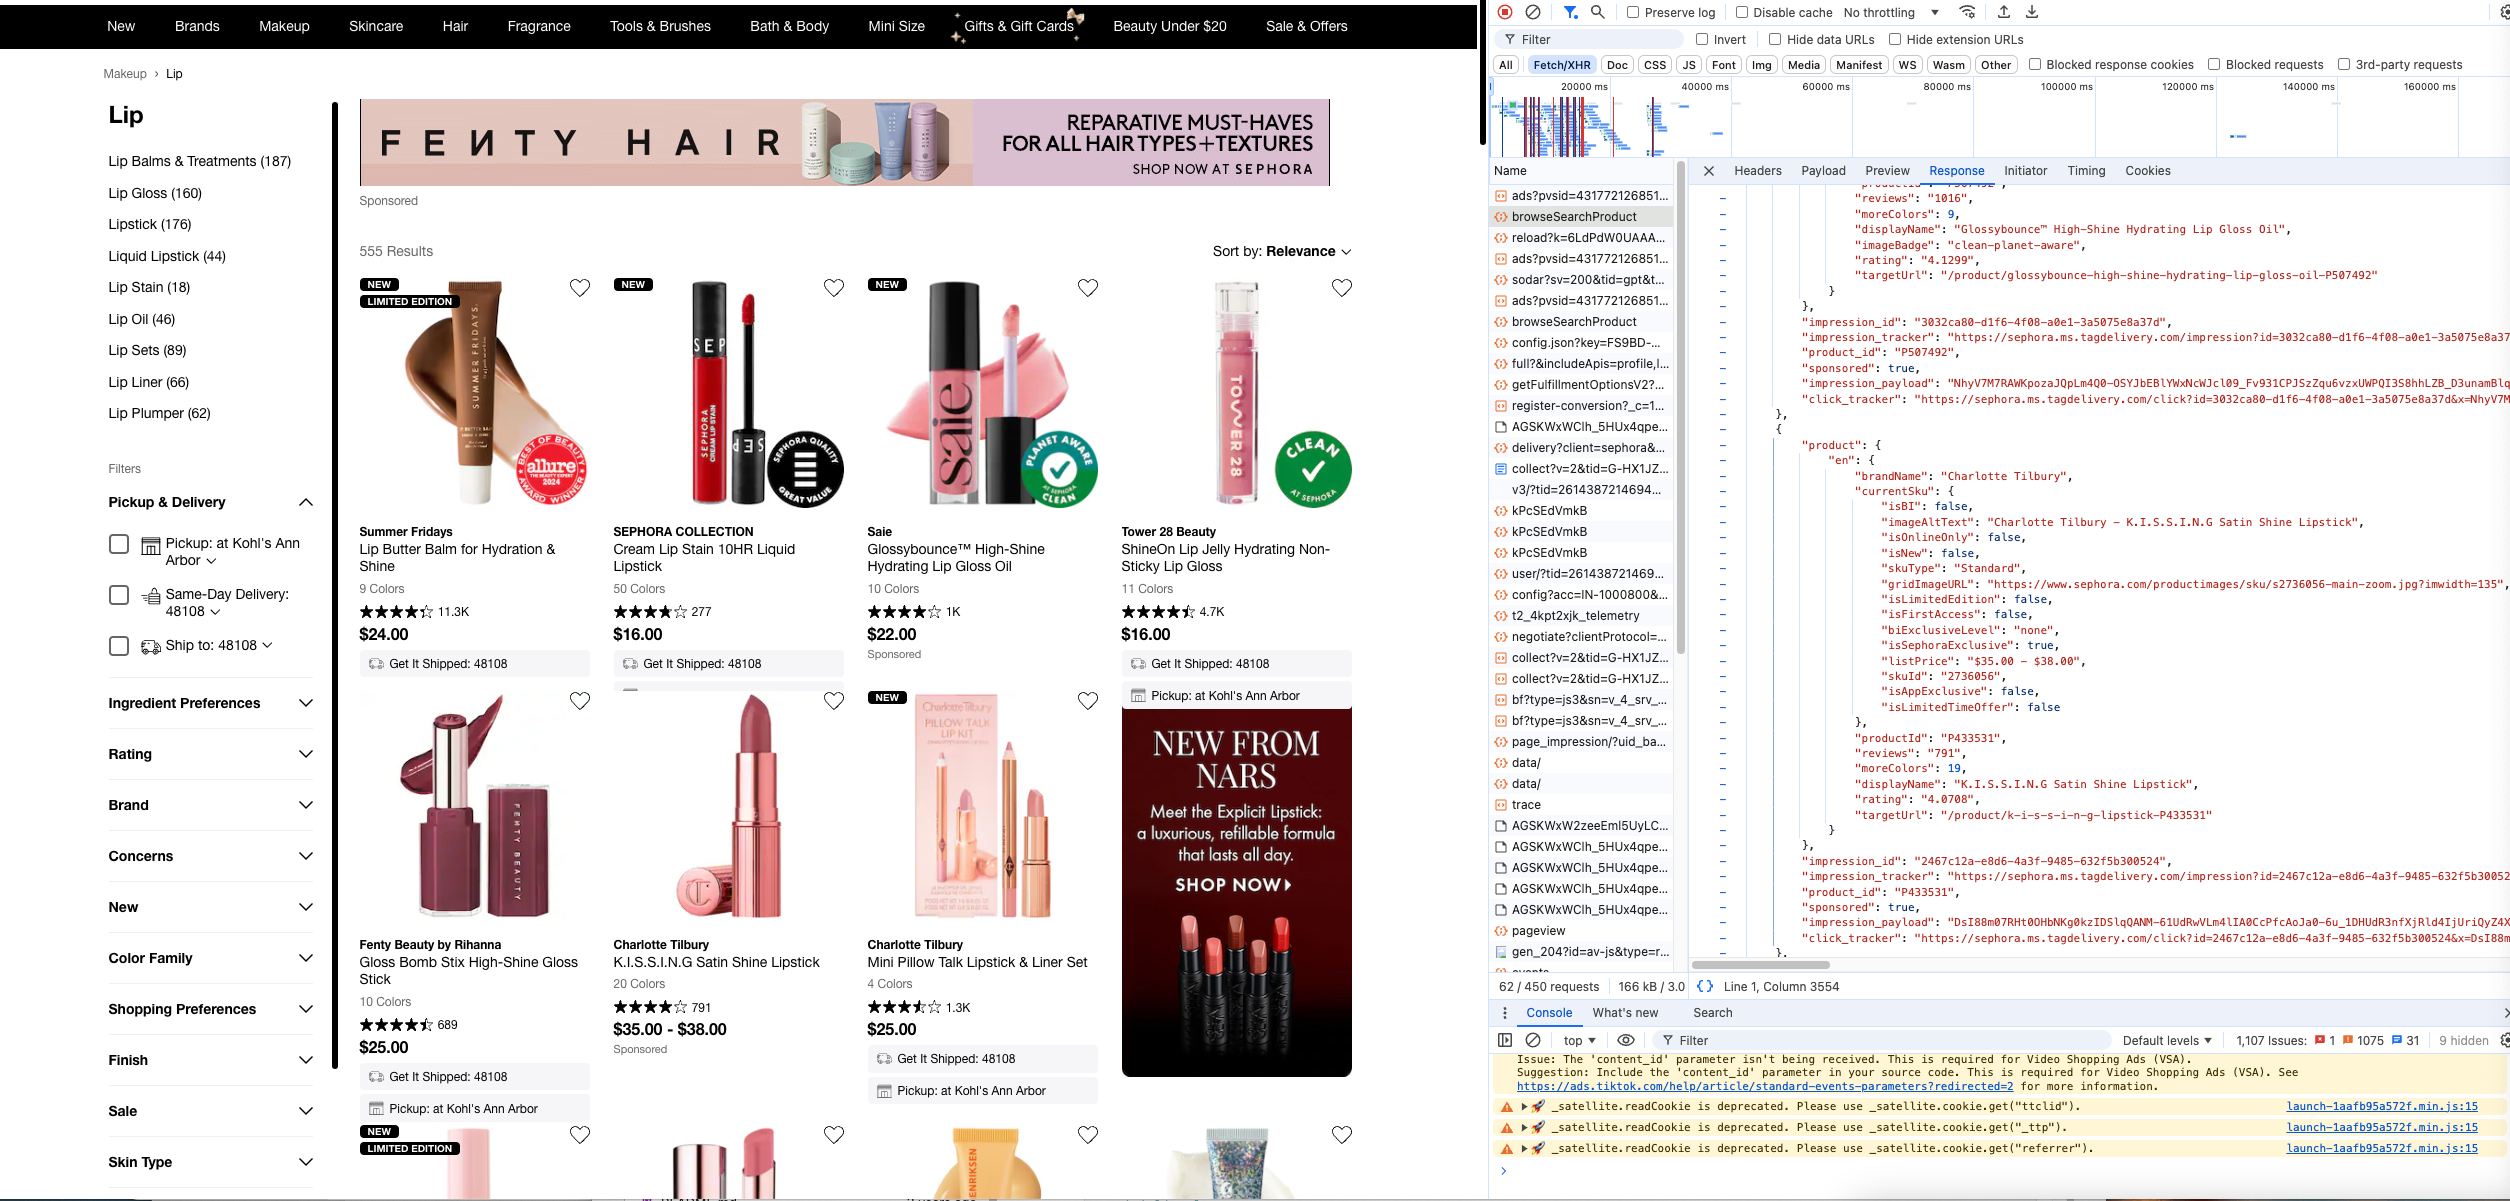




In [15]:
def load_page_data():
    page_path = "raw_data/products/page_data"
    page_data = []
    
    for file_name in os.listdir(page_path):
        if file_name.endswith('.json'):
            with open(os.path.join(page_path, file_name),'r') as f:
                page_data.append(json.loads(f.read().replace("True", "true").replace("False", "false")))
                
    return page_data

In [16]:
page_data = load_page_data()

In [17]:
df_product_ids = pd.concat([pd.json_normalize(d['products']) for d in page_data])

In [18]:
df_product_ids.tail(2)

,brandName,displayName,heroImage,altImage,moreColors,onSaleData,productId,rating,reviews,pickupEligible,...,currentSku.isLimitedTimeOffer,currentSku.isNatural,currentSku.isNew,currentSku.isOnlineOnly,currentSku.isOrganic,currentSku.isSephoraExclusive,currentSku.listPrice,currentSku.salePrice,currentSku.skuId,currentSku.skuType
58,tarte,Maracuja Juicy Lip Balm Best Sellers Duo,https://www.sephora.com/productimages/sku/s280...,https://www.sephora.com/productimages/sku/s280...,NaN,NONE,P512603,5,1,True,...,False,False,True,False,False,True,$29.00,NaN,2802239,Standard
59,Givenchy,Rose Perfecto Lip Balm 24H Hydration,https://www.sephora.com/productimages/sku/s274...,https://www.sephora.com/productimages/sku/s274...,10.0,NONE,P472700,4.4106,984,False,...,False,False,False,False,False,False,$39.00,NaN,2749539,Standard


In [19]:
df_product_ids['productId'].nunique()

323

In [12]:
Save the product list into pickle file
file_path = "json_dictionary_lipstick_category_product_list.pkl"
with open(file_path, 'wb') as file:
    pkl.dump(df_product_ids)

# Step 2.1: Extract Details from Each Product Page

For each product, additional details such as likes, total reviews, price, and more 
can be extracted from the product page using its URL. The data is saved in a 
dictionary, with the page content stored in BeautifulSoup format for easier parsing.

Steps:
1. Construct the product URL using the product's unique identifier (PID).
   Example: `product_url = 'https://www.sephora.com/product/' + PID`
2. Use the requests library to fetch the HTML content of the product page.
3. Parse the HTML content using BeautifulSoup for structured data extraction.
4. Extract relevant information such as:
   - Likes
   - Total reviews
   - Price
   - Additional product metadata
5. Save the extracted data in a dictionary for further analysis.

In [13]:
def get_data(product_link, px_list=None):
    """Get product information including swatch images and SKU-color mapping."""
    data_dic = {
        'pd_id': [], 
        'size_and_item': [], 
        'category': [], 
        'price': [], 
        'love_count': [], 
        'reviews_count': [], 
        'swatch_images': [],
        'sku_color_mapping': {},  
        'soup':[]
    }
    
    px_idx = 0
    proxy = None if px_list is None else px_list[px_idx]

    while True:
        try:
            # print(proxy, product_link)
            response = requests.get(product_link, proxies={"http": proxy, "https": proxy}, headers=headers, timeout=15)
        except:
            continue

        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
        

        try:
            data_dic['pd_id'] = re.findall(r'P[0-9]{3,6}', product_link)[0]
        except:
            data_dic['pd_id'] = None

        try:
            cat_box = soup.find_all(attrs={'data-comp': 'ProductBreadCrumbs BreadCrumbs '})[0]
            cat_list = [cat.string for cat in cat_box.find_all('a')]
            category = ', '.join(cat_list)
        except:
            category = None

        try:
            size_and_item = soup.find(attrs={"data-at": "sku_size_label"}).get_text()
        except:
            size_and_item = None

        try:
            price = soup.find_all(attrs={'data-comp': 'Price '})[0].get_text()
        except:
            price = None
        try:
            love_count = soup.find('span', attrs={"class": "css-jk94q9"}).get_text()
        except:
            love_count = None
        try:
            reviews = soup.find('span', attrs={'data-at': 'number_of_reviews'}).get_text()
            reviews_count = reviews
        except:
            reviews_count = None

        # Extract Swatch Images and SKU-Color Mapping
        try:
            swatch_group = soup.find_all(attrs={'data-comp': 'SwatchGroup '})
            swatch_images = []
            sku_color_mapping = {}

            for group in swatch_group:
                for button in group.find_all('button'):
                    aria_label = button.get('aria-label')
                    if aria_label:
                        sku_id = re.findall(r's[0-9]+', button.find('img')['src'])  # Extract SKU from image src
                        if sku_id:
                            sku_id = sku_id[0][1:]  # Remove the 's' prefix from SKU ID
                            sku_color_mapping[sku_id] = aria_label

                    img = button.find('img')
                    if img and 'src' in img.attrs:
                        swatch_images.append(img.attrs['src'])

            data_dic['swatch_images'] = swatch_images
            data_dic['sku_color_mapping'] = sku_color_mapping
        except:
            data_dic['swatch_images'] = []
            data_dic['sku_color_mapping'] = {}

        data_dic['category'] = category
        data_dic['size_and_item'] = size_and_item
        data_dic['love_count'] = love_count
        data_dic['reviews_count'] = reviews_count
        data_dic['price'] = price
        data_dic['soup'] = soup
        break

    return data_dic


In [ ]:
result=[]
for productId in tqdm(df_product_ids['productId'].unique()[3:], desc="Processing Products", unit="product"):
    # Construct Product URL from PID
    product_url = f'https://www.sephora.com/product/{productId}' 
    time.sleep(0.5)  # Delay to prevent hitting server too quickly
    result.append(get_data(product_url, None))

In [14]:
file_path = 'raw_data/products/downloaded_product_info_page_2024-09-28-2.pkl'

Open the file in binary write mode and save using pickle
with open(file_path, 'wb') as file:
    pickle.dump(result, file)

print(f"Data successfully saved to {file_path}")

Data successfully saved to raw_data/products/downloaded_product_info_page_2024-09-28-2.pkl


### Read again to check if the data is correct

In [15]:
file_path = 'raw_data/products/downloaded_product_info_page_2024-09-28-2.pkl'

with open(file_path, 'rb') as file:
    result = pickle.load(file)

print(f"Data successfully read from {file_path}")

Data successfully read from raw_data/products/downloaded_product_info_page_2024-09-28-2.pkl


In [16]:
df_product_info = pd.json_normalize(result)

In [17]:
len(df_product_info)

323

In [18]:
df_product_info.head(2)

,pd_id,size_and_item,category,price,love_count,reviews_count,swatch_images,soup,sku_color_mapping.2297505,sku_color_mapping.2486769,...,sku_color_mapping.2244093,sku_color_mapping.2244333,sku_color_mapping.2763241,sku_color_mapping.2763365,sku_color_mapping.2709368,sku_color_mapping.2023471,sku_color_mapping.1917244,sku_color_mapping.2490217,sku_color_mapping.2182806,sku_color_mapping.2182855
0,P451920,Size .15 oz/ 4.6 mL,,$22.00get it for $20.90 (5% off) with Auto-Rep...,203.4K,966,[https://www.sephora.com/productimages/sku/s22...,"[html, \n, [[<title>Clean Wet Lip Oil Gloss - ...",Jellyfish clear,Unbuttoned soft warm blush,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P508676,None,,$7.00or 4 payments of $1.75 with or,23.6K,87,[],"[html, \n, [[<title>Hot Cocoa Lip Sleeping Mas...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
images_url = list(set(df_product_info['swatch_images'].sum()))

In [20]:
len(images_url)

1264

# Step 2.2 Download Images

From the product list details, we can download the images from images_url list

In [21]:
def download_image(image_url, folder='raw_data/images'):
    """
    Download an image from a URL and save it into the specified folder without altering the format.
    Skip the download if the image already exists in the folder.
    """
    try:
        if not os.path.exists(folder):
            os.makedirs(folder)

        image_name = image_url.split('/')[-1]
        image_path = os.path.join(folder, image_name)

        if os.path.isfile(image_path):
            print(f"Image already exists, skipping download: {image_path}")
            return

        response = requests.get(image_url, headers=headers)

        if response.status_code == 200 and 'image' in response.headers['Content-Type']:
            # Write the image content directly to the file
            with open(image_path, 'wb') as f:
                f.write(response.content)
            print(f"Image successfully downloaded: {image_path}")
        else:
            print(f"Failed to download image. Status code: {response.status_code} or incorrect content type: {response.headers.get('Content-Type')}")

    except Exception as e:
        print(f"An error occurred: {e}")



In [ ]:
import time
from tqdm import tqdm  # Import tqdm for progress bar

ct = 0
# Wrap the loop using tqdm to show a progress bar
for image_url in tqdm(images_url, desc="Processing Products", unit="product"):
    time.sleep(0.5)  # Delay to prevent hitting server too quickly
    download_image(image_url)
    ct+=1

print(ct)

# Step3: Reviews

From previous step, we already have all product_ids.

In this step, we use API to fetch customer review.


In [22]:
pd_links_df = df_product_ids.copy()

In [23]:
# # Webscrap products from M1

# from previous M1, we have previous historical reviews downloaded last time.
# We use max date to ensure we don't need to download the existing reviews before our previous downloads

with open("raw_data/previous_reviews_downloaded/max_date_per_product.pkl", 'rb') as file:
    s_last_review =  pickle.load(file)

In [24]:
s_last_review.head()

ProductId
1005438    2021-04-29T19:32:12.000+00:00
1005446    2021-02-22T23:39:40.000+00:00
1005453    2018-11-05T05:50:22.000+00:00
1005461    2018-09-06T20:40:43.000+00:00
1005479    2018-06-13T21:09:27.000+00:00
Name: SubmissionTime, dtype: object

In [25]:
# Join the last review date to the current product table
pd_links_df = pd_links_df.merge(pd.DataFrame(s_last_review), left_on='productId', right_on='ProductId', how='left')

# If no date available, we default to download reviews as far as 2018-01-01
pd_links_df['SubmissionTime'] = pd_links_df['SubmissionTime'].fillna('2018-01-01T00:00:00.000+00:00')

In [26]:
len(pd_links_df)

323

In [27]:
pd_links_df.head()

,brandName,displayName,heroImage,altImage,moreColors,onSaleData,productId,rating,reviews,pickupEligible,...,currentSku.isNatural,currentSku.isNew,currentSku.isOnlineOnly,currentSku.isOrganic,currentSku.isSephoraExclusive,currentSku.listPrice,currentSku.skuId,currentSku.skuType,currentSku.salePrice,SubmissionTime
0,Kosas,Wet Lip Oil Plumping Peptide Lip Treatment Gloss,https://www.sephora.com/productimages/sku/s248...,https://www.sephora.com/productimages/sku/s248...,10.0,NONE,P451920,3.7847,966,True,...,False,False,False,False,False,$22.00,2486769,Standard,NaN,2021-04-14T00:59:50.000+00:00
1,SEPHORA COLLECTION,Hot Cocoa Lip Sleeping Mask,https://www.sephora.com/productimages/sku/s268...,NaN,NaN,NONE,P508676,3.7586,87,True,...,False,False,False,False,True,$7.00,2680395,Standard,NaN,2018-01-01T00:00:00.000+00:00
2,iNNBEAUTY PROJECT,Glaze Lip Oil,https://www.sephora.com/productimages/sku/s276...,https://www.sephora.com/productimages/sku/s276...,9.0,NONE,P471038,4.2832,459,False,...,False,False,True,False,False,$18.00,2763902,Standard,NaN,2018-01-01T00:00:00.000+00:00
3,Ami Colé,Desert Date Cream Blush & Lip Multistick,https://www.sephora.com/productimages/sku/s278...,https://www.sephora.com/productimages/sku/s278...,4.0,NONE,P504779,4.8095,126,False,...,False,True,True,False,True,$22.00,2780757,Standard,NaN,2018-01-01T00:00:00.000+00:00
4,SEPHORA COLLECTION,Cream Lip Stain Liquid Lipstick Set,https://www.sephora.com/productimages/sku/s277...,https://www.sephora.com/productimages/sku/s277...,NaN,NONE,P512591,0,0,False,...,False,True,True,False,True,$38.00,2777803,Standard,NaN,2018-01-01T00:00:00.000+00:00


In [30]:
def convert_date_to_unix_milliseconds(date_string):
    """Convert ISO 8601 date string to Unix timestamp in milliseconds."""
    dt = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S.%f%z')
    timestamp_ms = int(dt.timestamp())
    return timestamp_ms

# Configuration settings from Sephora's JavaScript
configurations = {
    "bvApi_rwdRating_mWeb_read": {"host": "api.bazaarvoice.com", "token": "caHFIcND7how0aLS6wzoJhq0PcvkFllbfQUmnsxU3BMZo", "version": "5.4"},
    "bvApi_rwdRating_desktop_read": {"host": "api.bazaarvoice.com", "token": "calXm2DyQVjcCy9agq85vmTJv5ELuuBCF2sdg4BnJzJus", "version": "5.4"},
    "bvApi_rwdQandA_desktop_read": {"host": "api.bazaarvoice.com", "token": "cazL3EmmEkDTXVLkyJuBduSeyK74mqwEwstuHbbvmvvCk", "version": "5.4"},
}

def get_bazaarvoice_reviews(product_id, environment='bvApi_rwdRating_mWeb_read', limit=100, max_loops=130, start_date=None):
    """Fetch product reviews from Bazaarvoice API using the specified environment."""
    # Step 1: Choose the API configuration based on the environment
    if environment not in configurations:
        raise ValueError(f"Environment '{environment}' is not available in configurations.")

    # Extract host and token for the specified environment
    config = configurations[environment]
    host = config["host"]
    token = config["token"]
    version = config["version"]

    # Step 2: Define the API endpoint URL and request parameters
    url = f"https://{host}/data/reviews.json"
    params = {
        'Filter': [f'ProductId:{product_id}'],
        'Sort': 'SubmissionTime:desc',
        'Limit': limit,
        'Offset': 0,
        'Include': 'Products,Comments',
        'Stats': 'Reviews',
        'passkey': token,  # Use the environment-specific token
        'apiversion': version,  # Use the environment-specific version
        'Locale': 'en_US',
    }
    # Step 3: Add start date filter if provided
    if start_date:
        # Convert start date to Unix timestamp in milliseconds
        start_timestamp = convert_date_to_unix_milliseconds(start_date)
        # Append SubmissionTime filter using the timestamp
        params['Filter'].append(f'SubmissionTime:gt:{start_timestamp}')
    
    # Step 4: Iterate through the pages and fetch reviews
    reviews = []
    product = []
    loop = 0

    while loop < max_loops:
        # Update the offset parameter
        params['Offset'] = len(reviews)

        try:
            response = requests.get(url, params=params, timeout=15)
        except requests.exceptions.RequestException as e:
            print(f"Error occurred during request: {e}")
            break

        try:
            response_json = response.json()
        except json.JSONDecodeError:
            print(f"Failed to decode JSON response. URL: {url}")
            break

        if response_json.get('HasErrors', False):
            print(f"Error in response: {response_json.get('Errors', 'Unknown error')}")
            break
        if loop == 0:
            try:
                product = response_json['Includes']['Products']
            except KeyError:
                product = []

        reviews.extend(response_json.get('Results', []))

        total_results = response_json.get('TotalResults', 0)
        if len(reviews) >= total_results:
            break

        # Pause between requests to avoid rate-limiting
        time.sleep(0.2)
        loop += 1

    print(f"{product_id}: {len(reviews)} reviews fetched.")
    return product, reviews

# Example Usage:
# product_id = 'P458268'
# product, reviews = get_bazaarvoice_reviews(product_id, environment='bvApi_rwdRating_mWeb_read', start_date = '2024-09-26T01:55:23.000+00:00')


To ensure we don't get blocked by the ip address
we use truncs to download
Change this 150: to a subset of products to download
pd_links_df['productId'][150:], pd_links_df['SubmissionTime'][150:] 

In [31]:
loop = 0
review_result = {}
start = time.ctime()
for pid, max_submission_ts in tqdm(zip(pd_links_df['productId'][150:151], pd_links_df['SubmissionTime'][150:151]), 
                                   desc="Processing Products", 
                                   unit="product"):

    # Get product and review data using the custom function
    product, reviews = get_bazaarvoice_reviews(pid, environment='bvApi_rwdRating_mWeb_read', start_date=max_submission_ts)
    print(max_submission_ts, pid)

    loop += 1
    review_result[pid] = [product, reviews]


Processing Products: 1product [00:01,  1.79s/product]

P506789: 389 reviews fetched.
2018-01-01T00:00:00.000+00:00 P506789


In [ ]:
# Estimated time from logging:
# Processing Products: 173product [05:34,  1.94s/product]

# Save to file

Save to a new file when downloading in trunk
We downloaded 4 times and append all in the review_result dictionary
In total we have 14 files (13 times from previous review, 1 time from current download)

In [ ]:
with open("raw_data/reviews/Copy of scraper_result14.json", "w") as file:
    json.dump(review_result, file)